# e/iso/sQTL overlap
- `pi0`: the proportion of true null association based on their distribution
- `pi1=1-pi0` estimates the lower bound of true positive associations
- `lambda = 0` meaning `pi0 = 1`
- Notes
    - tried nominal association, large file; tested with one chunk, see results below
    - tried w/ and w/o filling in NA p-val with random uniform distribution; ERROR when w/o
    - tried use permutation/primary gene-QTL assoc for both groups, bad result (many missing, too many random fill)
    - `qvalue` error when no right tail of p-val distribution "The p-values are relatively flat at the right tail of the histogram. This is an important step in determining whether the true null p-values are distributed according to a Uniform(0,1) distribution" (from qvalue package)
    - **final: permutation significant gene-SNP pair in discovery group, filling in NA pval nominal association for replication group**
    - what to use for `lambda`? `seq(0.2, 0.8, 0.1)` as in Jason Stein's paper makes minimal difference to w/o `lambda` for nominal chunk testing
    - `pval_beta` and `pval_nominal` makes minimal difference, see below
    - nominal association isoqtl, sqtl keep gene-SNP pairs with best nominal p-val

In [1]:
library(data.table)
library(tidyverse)
library(qvalue)
library(viridis)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: viridisLite



In [2]:
setwd("~/project-gandalm/isoform_twas/")

### 1: iso/s QTL replicated in eQTL

In [38]:
isoqtl <- fread("isoqtl_new/results/mixed_grp_perm_70hcp/group.perm.genes.txt.gz", data.table = F)
sqtl <- fread("sqtl_new/results/mixed_grp_perm_40hcp_1e6/group.perm.genes.txt.gz", data.table = F)
eqtl_nominal <- eqtl_nominal <- fread("eqtl_new/results/mixed_nominal_70hcp/chunk1.txt.gz", data.table = F)

In [39]:
isoqtl <- isoqtl %>% separate(gene_id, c("pheno", "gene"), remove = FALSE, sep = ":") %>%
    unite("gene_qtl", gene, variant_id, remove = FALSE, sep = ":")

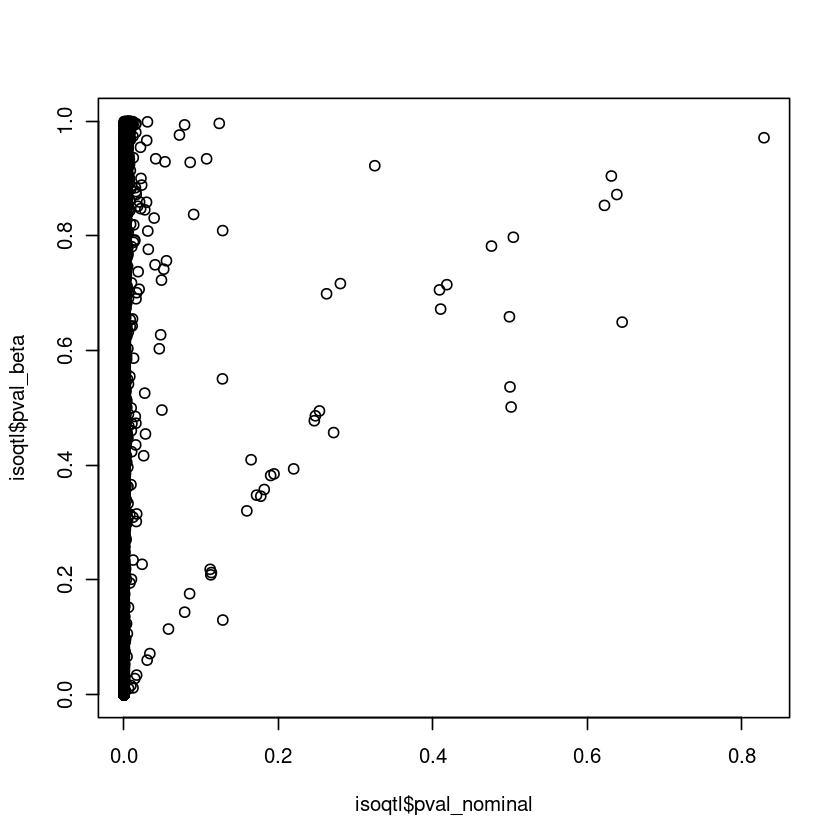

In [40]:
plot(isoqtl$pval_nominal, isoqtl$pval_beta)

In [35]:
dim(isoqtl)
length(unique(isoqtl$gene_qtl))

[1] 30752    24

[1] 30746

In [41]:
isoqtl <- isoqtl %>% arrange("gene_qtl", pval_beta)
isoqtl <- isoqtl[!duplicated(isoqtl$gene_qtl),]

In [42]:
sqtl <- sqtl %>% separate(gene_id, c("chr", "start", "end", "clu", "ensg", "gene_name"), sep = ":") %>%
    separate(ensg, c("gene", "version"), sep = "[.]") %>%
    unite("gene_qtl", gene, variant_id, sep = ":")

In [43]:
dim(sqtl)
length(unique(sqtl$gene_qtl))
sqtl <- sqtl %>% arrange("gene_qtl", pval_beta)
sqtl <- sqtl[!duplicated(sqtl$gene_qtl),]
dim(sqtl)
length(unique(sqtl$gene_qtl))

[1] 18424    26

[1] 16503

[1] 16503    26

[1] 16503

In [44]:
colnames(eqtl_nominal) <- c("pid","sid","dist","npval","slope")
eqtl_nominal <- eqtl_nominal %>% unite("gene_qtl", pid, sid, remove = FALSE, sep = ":")

[1] 11857    29

[1] 11697

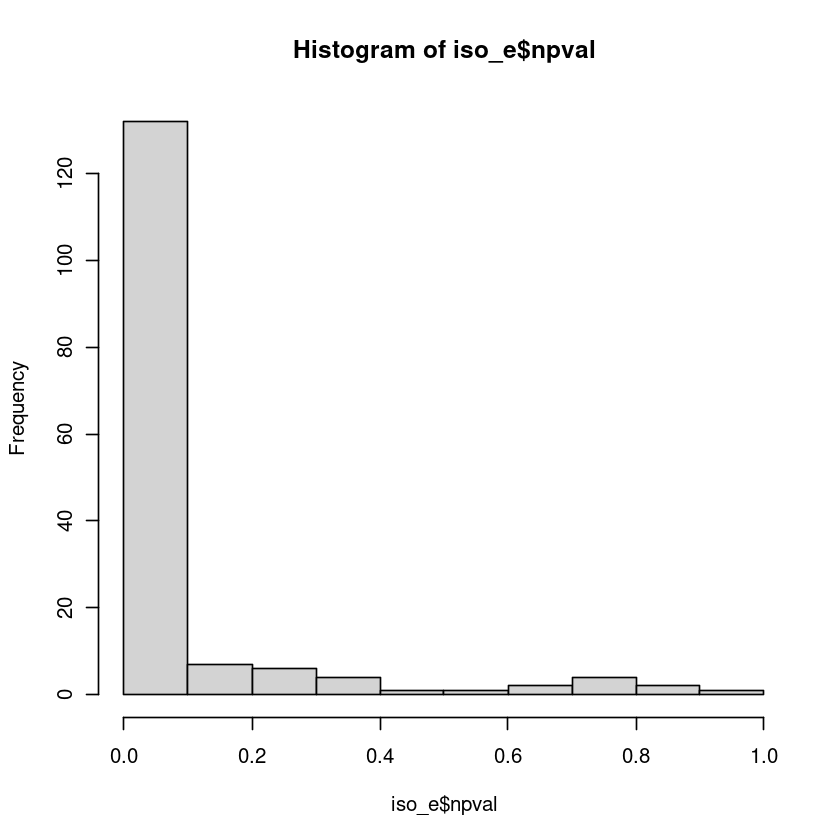

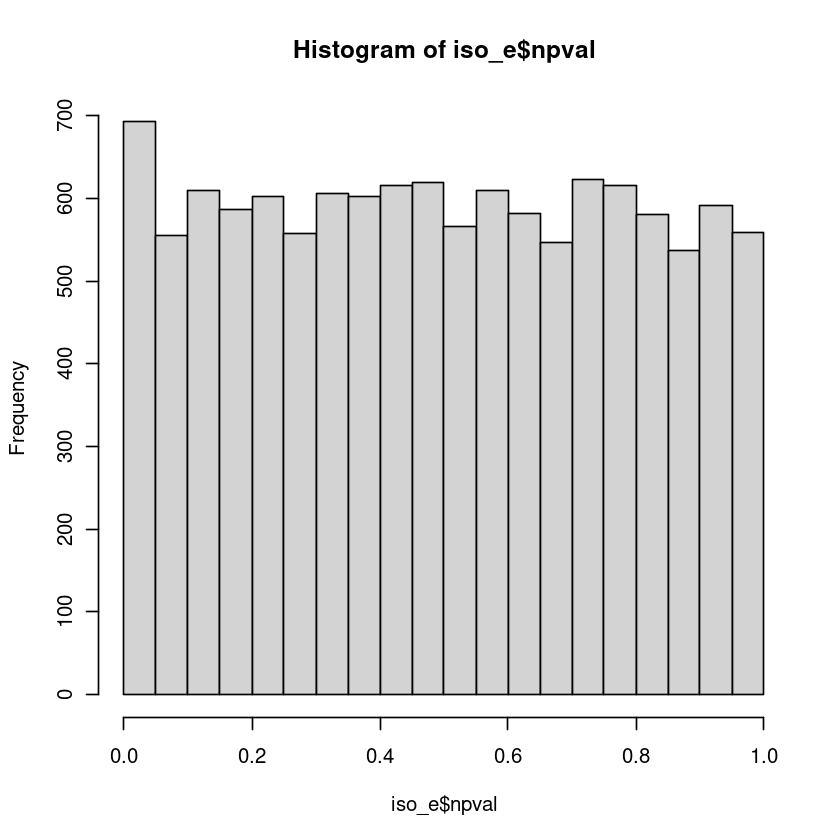

In [45]:
iso_e <- isoqtl %>%
    filter(qval < 0.05) %>%
    left_join(eqtl_nominal, by = "gene_qtl")
dim(iso_e)
hist(iso_e$npval)
sum(is.na(iso_e$npval))
for(i in 1:nrow(iso_e)) {
    if(is.na(iso_e[i,'npval'])) {
        iso_e[i,'npval'] <- runif(1, min = 0, max = 1)
    }
}
hist(iso_e$npval)

In [46]:
(qvalue(iso_e$npval))$pi0
(qvalue(iso_e$npval, lambda = seq(0.2, 0.8, 0.1)))$pi0

[1] 0.9522103

[1] 0.9636783

In [47]:
s_e <- sqtl %>%
    filter(qval < 0.05) %>%
    left_join(eqtl_nominal, by = "gene_qtl")
sum(is.na(s_e$npval))
for(i in 1:nrow(s_e)) {
    if(is.na(s_e[i,'npval'])) {
        s_e[i,'npval'] <- runif(1, min = 0, max = 1)
    }
}

(qvalue(s_e$npval))$pi0
(qvalue(s_e$npval, lambda = seq(0.2, 0.8, 0.1)))$pi0

[1] 7512

[1] 0.9876258

[1] 0.9654463

### 2: e/sQTL replicated in isoQTL

### 3: e/isoQTL replicated in sQTL

In [3]:
isoqtl <- fread("isoqtl_new/results/mixed_grp_perm_70hcp/group.perm.genes.txt.gz", data.table = F)
isoqtl <- isoqtl %>% 
    separate(gene_id, c("pheno", "gene"), remove = FALSE, sep = ":") %>%
    unite("gene_qtl", gene, variant_id, remove = FALSE, sep = ":") %>%
    arrange("gene_qtl", pval_beta)
isoqtl <- isoqtl[!duplicated(isoqtl$gene_qtl),]

eqtl <- fread("eqtl_new/results/mixed_perm_90hcp/sig_pheno.txt", data.table = F)
eqtl <- eqtl %>% 
    unite("gene_qtl", pid, sid, remove = FALSE, sep = ":")

In [5]:
ptm <- proc.time()

sqtl_nominal <- fread("sqtl_new/results/mixed_nominal_40hcp_1e6/chunk44.txt.gz", data.table = F)
load("sqtl_new/leafviz_annot/all.introns.tested.RData")
colnames(sqtl_nominal) <- c("pid","sid","dist","npval","slope")
sqtl_nominal <- sqtl_nominal %>% 
    left_join(pheno, by = c("pid" = "ID")) %>%
    separate(ensemblID, c("ensg", "ver"), sep = "[.]", remove = FALSE) %>%
    unite("gene_qtl", ensg, sid, remove = FALSE, sep = ":") %>%
    arrange('gene_qtl', npval)
sqtl_nominal <- sqtl_nominal[!duplicated(sqtl_nominal$'gene_qtl'),]

proc.time() - ptm

   user  system elapsed 
272.684  15.650 285.321 

In [7]:
ptm <- proc.time()

sqtl_nominal <- fread("sqtl_new/results/mixed_nominal_40hcp_1e6/chunk44.txt.gz", data.table = F)
load("sqtl_new/leafviz_annot/all.introns.tested.RData")
colnames(sqtl_nominal) <- c("pid","sid","dist","npval","slope")
sqtl_nominal <- sqtl_nominal %>% 
    select(pid, sid, npval) %>%
    left_join(pheno, by = c("pid" = "ID")) %>%
    separate(ensemblID, c("ensg", "ver"), sep = "[.]", remove = FALSE) %>%
    unite("gene_qtl", ensg, sid, remove = FALSE, sep = ":") %>%
    arrange('gene_qtl', npval) %>%
    select(gene_qtl, npval)
sqtl_nominal <- sqtl_nominal[!duplicated(sqtl_nominal$'gene_qtl'),]

proc.time() - ptm

   user  system elapsed 
248.334   7.732 252.672 

In [9]:
e_s <- eqtl %>%
    left_join(sqtl_nominal, by = "gene_qtl")
sum(is.na(e_s$npval.y))
for(i in 1:nrow(e_s)) {
    if(is.na(e_s[i,'npval.y'])) {
        e_s[i,'npval.y'] <- runif(1, min = 0, max = 1)
    }
}
(qvalue(e_s$npval.y))$pi0
(qvalue(e_s$npval.y, lambda = seq(0.2, 0.8, 0.1)))$pi0

[1] 10041

[1] 1

[1] 1

In [76]:
df <- data.frame("grp1" = c("eQTL", "isoQTL", "eQTL", "sQTL", "isoQTL", "sQTL", "eQTL", "isoQTL", "sQTL"),
                 "grp2" = c("isoQTL", "eQTL", "sQTL", "eQTL", "sQTL", "isoQTL", "eQTL", "isoQTL", "sQTL"),
                 "pi1" = c(1-Q_e_iso$pi0, 1-Q_iso_e$pi0, 1-Q_e_s$pi0, 
                           1-Q_s_e$pi0, 1-Q_iso_s$pi0, 1-Q_s_iso$pi0,
                           1, 1, 1))

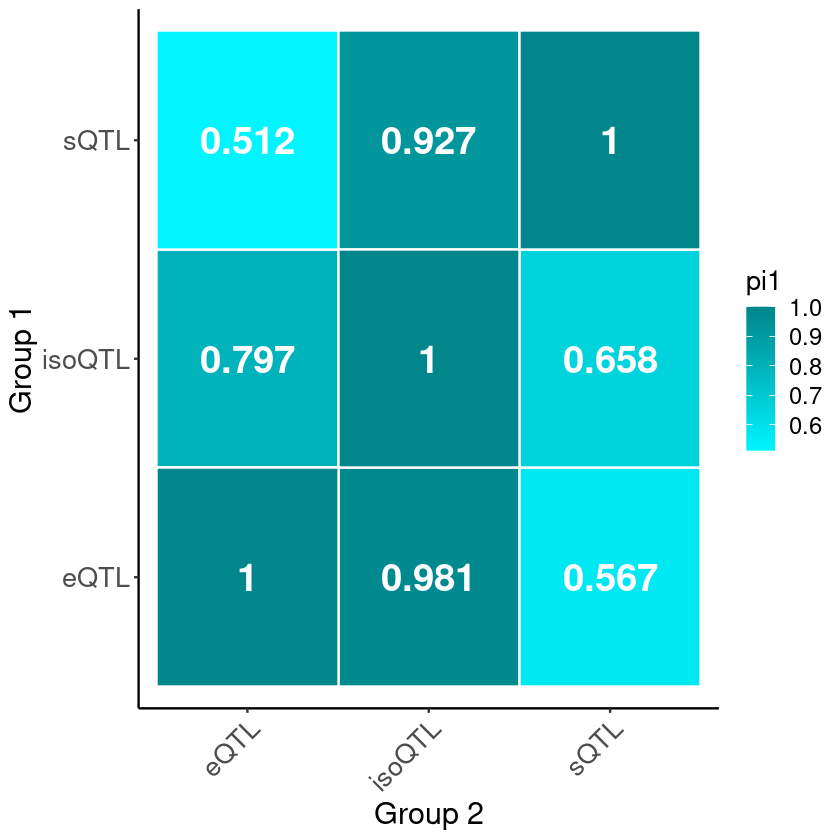

In [83]:
df$grp1 <- factor(df$grp1, levels = c("eQTL", "isoQTL", "sQTL"))
df$grp2 <- factor(df$grp2, levels = c("eQTL", "isoQTL", "sQTL"))

p <- ggplot(df, aes(x = grp2, y = grp1, fill = pi1)) +
    geom_tile(colour = "white", size = 0.5) +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "right") +
    scale_fill_gradient(low = "turquoise1", high = "turquoise4") +
    geom_text(aes(label = signif(pi1, 3)), color = "white", size = 8, fontface = "bold") +
    labs(x = "Group 2", y = "Group 1")
p

**Final results**

In [3]:
df <- data.frame("grp1" = c("eQTL", "isoQTL", "eQTL", "sQTL", "isoQTL", "sQTL", "eQTL", "isoQTL", "sQTL"),
                 "grp2" = c("isoQTL", "eQTL", "sQTL", "eQTL", "sQTL", "isoQTL", "eQTL", "isoQTL", "sQTL"),
                 "pi1" = c(1-0.02046428, 1-0.1159089, 1-0.388718, 
                           1-0.401189, 1-0.3709601, 1-0.06178486,
                           1, 1, 1))

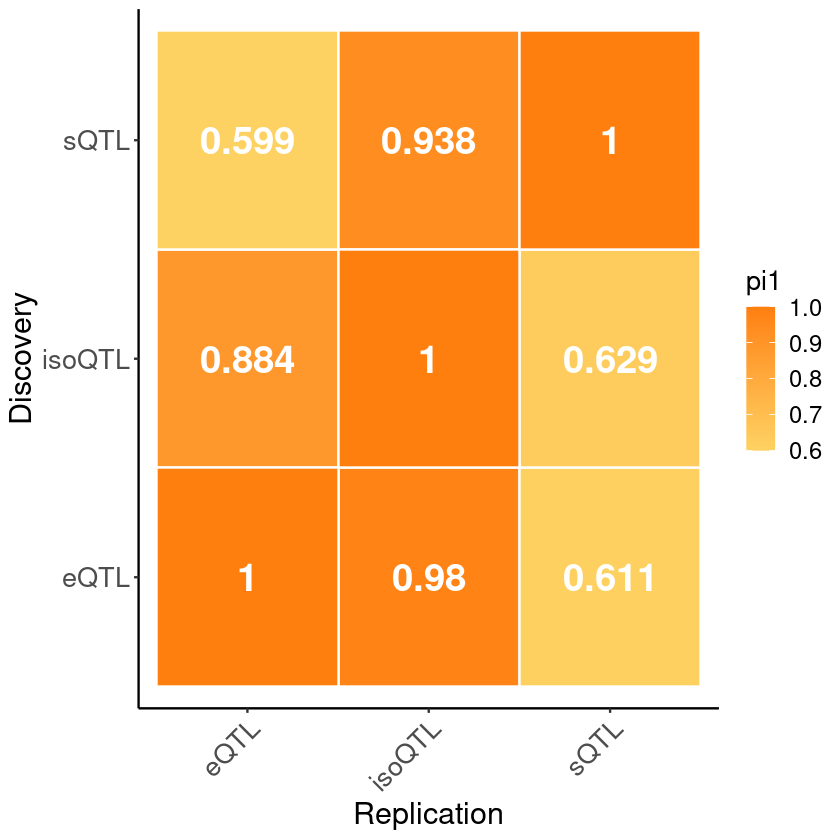

In [4]:
df$grp1 <- factor(df$grp1, levels = c("eQTL", "isoQTL", "sQTL"))
df$grp2 <- factor(df$grp2, levels = c("eQTL", "isoQTL", "sQTL"))

p <- ggplot(df, aes(x = grp2, y = grp1, fill = pi1)) +
    geom_tile(colour = "white", size = 0.5) +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "right") +
    scale_fill_gradient(low = '#FDD262', high = '#FF7F0E') +
#     scale_fill_distiller(direction = 1, palette = "Blues") +
#     scale_fill_viridis(option = "plasma") + 
    geom_text(aes(label = signif(pi1, 3)), color = "white", size = 8, fontface = "bold") +
    labs(x = "Replication", y = "Discovery")
p

In [5]:
ggsave("sqtl_new/figures/pi1.pdf", p, height = 6, width = 6)

In [4]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/mkl/lib/intel64_lin/libmkl_gf_lp64.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] qvalue_2.24.0     forcats_0.5.1     stringr_1.4.0     dplyr_1.0.6      
 [5] purrr_0.3.4       readr_1.4.0       tidyr_1.1.3       tibble_3.1.2     
 [9] ggplot2_3.3.3     tidyverse_1.3.1   data.table_1.14.0

loaded via a namespace (and not attached):
